In [1]:
import numpy as np
from tqdm import tqdm

import gymnasium as gym

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

# Environment

In [3]:
IMG_STACK = 4

transition = np.dtype([
    ('s', np.float64, (IMG_STACK, 84, 84)), 
    ('a', np.float64, (3,)), 
    ('a_logp', np.float64),
    ('r', np.float64), 
    ('s_', np.float64, (IMG_STACK, 84, 84))
])

In [4]:
class CarRacingEnv:
    """
    Environment wrapper for CarRacing
    """

    def __init__(self, skip_frames=4, render_mode=None):
        self.env = gym.make('CarRacing-v2', render_mode)
        self.skip_frames = skip_frames
        
    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        img_rgb, info = self.env.reset()

         # Skip the first 50 frames with no action
        for _ in range(50):
            img_rgb, _, _, _, _ = self.env.step([0, 0, 0])
        
        img_gray = self.rgb2gray(img_rgb)
        self.stack = [img_gray] * IMG_STACK 
        return np.array(self.stack), info

    def step(self, action):
        total_reward = 0
        for i in range(self.skip_frames):
            img_rgb, reward, done, truncated, _ = self.env.step(action)
            # don't penalize "die state"
            if done or truncated:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            die = True if self.av_r(reward) <= -0.1 else False
            if done or truncated or die:
                break
        truncated = True if die else truncated
        img_gray = self.rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == IMG_STACK
        return np.array(self.stack), total_reward, done, truncated

    def render(self, *arg):
        self.env.render(*arg)

    def rgb2gray(self, rgb, norm=True):
        """
        Convert RGB image to grayscale and normalize it.
        
        Parameters:
        - rgb: The RGB image input.
        - norm: Boolean indicating whether to normalize the output.
        
        Returns:
        - The processed grayscale image, cropped and normalized to [-1, 1] interval.
        """
        # Crop the image to focus on relevant parts
        cropped_rgb = rgb[:84, 6:90]
        # Convert cropped image to grayscale
        gray = np.dot(cropped_rgb[..., :3], [0.299, 0.587, 0.114])
        if norm:
            # Normalize to [-1, 1] interval
            gray = gray / 127.5 - 1.
        return gray

    
    def reward_memory(self):
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

# Networks

In [5]:
class Net(nn.Module):
    def __init__(self, cnn_config, ff_config, input_shape):
        super(Net, self).__init__()
        
        # Initialize CNN base
        self.cnn_base = nn.Sequential()
        for i, (in_channels, out_channels, kernel_size, stride) in enumerate(cnn_config['layers']):
            self.cnn_base.add_module(f'conv{i}', nn.Conv2d(in_channels, out_channels, kernel_size, stride))
            self.cnn_base.add_module(f'relu{i}', nn.ReLU())

        cnn_output_size = self._get_conv_output(input_shape)
        last_fc_output_size = ff_config['fc'][-1][0]  
        
        self.v = self._build_sequential(ff_config['v'], cnn_output_size)
        self.fc = self._build_sequential(ff_config['fc'], cnn_output_size)
        self.alpha_head = self._build_sequential(ff_config['head'], last_fc_output_size)
        self.beta_head = self._build_sequential(ff_config['head'], last_fc_output_size)

        self.apply(self._weights_init)

    def _build_sequential(self, config, input_dim):
        layers = nn.Sequential()
        for i, (out_features, activation) in enumerate(config):
            layers.add_module(f'linear{i}', nn.Linear(input_dim, out_features))
            if activation == 'relu':
                layers.add_module(f'activation{i}', nn.ReLU())
            elif activation == 'softplus':
                layers.add_module(f'activation{i}', nn.Softplus())
            input_dim = out_features  
        return layers

    def _get_conv_output(self, shape):
        with torch.no_grad():  # No need to track gradients here
            input = torch.autograd.Variable(torch.rand(1, *shape))
            output_feat = self.cnn_base(input)
            n_size = output_feat.data.view(1, -1).size(1)
        return n_size

    def _weights_init(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(x.size(0), -1) 
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1
        return (alpha, beta), v

# Replay Buffer and Agent

In [6]:
class ReplayBuffer:
    """
    A simple NumPy replay buffer for storing transitions.
    """

    def __init__(self, capacity, transition_dtype):
        """
        Initialize the replay buffer.

        Parameters:
        - capacity: The maximum number of transitions the buffer can hold.
        - transition_dtype: The dtype of the stored transitions, typically a structured array dtype.
        """
        self.capacity = capacity
        self.storage = np.empty(capacity, dtype=transition_dtype)
        self.counter = 0

    def store(self, transition):
        """
        Store a transition in the buffer.

        Parameters:
        - transition: The transition to store.
        """
        self.storage[self.counter] = transition
        self.counter += 1
        if self.counter == self.capacity:
            self.counter = 0

    def sample(self, batch_size):
        """
        Sample a batch of transitions from the buffer.

        Parameters:
        - batch_size: The number of transitions to sample.

        Returns:
        - A batch of sampled transitions.
        """
        indices = np.random.choice(min(self.capacity, self.counter), size=batch_size, replace=False)
        return self.storage[indices]

In [7]:
class PPOAgent:
    """
    Agent for training
    """
    def __init__(self, network, lr=0.001, gamma=0.99, clip_epsilon=0.2, max_grad_norm=0.1, ppo_steps=4, buffer_capacity=1000, batch_size=64):
        self.training_step = 0
        self.network = network.double().to(device)
        self.buffer_capacity = buffer_capacity
        self.buffer = ReplayBuffer(buffer_capacity, transition)
        self.batch_size = batch_size
        self.gamma = gamma
        self.clip_param = clip_epsilon
        self.ppo_steps = ppo_steps
        self.max_grad_norm = max_grad_norm
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        self.total_rewards_history = []
        self.mean_rewards_history = []

    
    def select_action(self, state):
        state = torch.from_numpy(state).double().to(device).unsqueeze(0)
        with torch.no_grad():
            alpha, beta = self.network(state)[0]
        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp, dist

    
    def store(self, transition):
        self.buffer.store(transition)

    
    def learn(self):
        s = torch.tensor(self.buffer.storage['s'], dtype=torch.double).to(device)
        a = torch.tensor(self.buffer.storage['a'], dtype=torch.double).to(device)
        r = torch.tensor(self.buffer.storage['r'], dtype=torch.double).to(device).view(-1, 1)
        s_ = torch.tensor(self.buffer.storage['s_'], dtype=torch.double).to(device)
        old_a_logp = torch.tensor(self.buffer.storage['a_logp'], dtype=torch.double).to(device).view(-1, 1)

        with torch.no_grad():
            target_v = r + self.gamma * self.network(s_)[1]
            adv = target_v - self.network(s)[1]

        for _ in range(self.ppo_steps):
            for index in BatchSampler(SubsetRandomSampler(range(self.buffer.counter)), self.batch_size, False):
                alpha, beta = self.network(s[index])[0]
                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp - old_a_logp[index])

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(self.network(s[index])[1], target_v[index])
                loss = action_loss + 2. * value_loss

                self.optimizer.zero_grad()
                loss.backward()
                if self.max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(self.network.parameters(), self.max_grad_norm)
                self.optimizer.step()


    def train(self, env, episodes=2000, update_interval=1):
        # Initialize lists for plotting
        alpha_lists = [[], [], []]  # Assuming 3 actions for simplicity; adjust as needed
        beta_lists = [[], [], []]
        steps_list = []  
        buffer_n_list = []
        for i_ep in tqdm(range(episodes)):
            state, _ = env.reset()
            episode_rewards = []
            episode_alphas = [[], [], []]
            episode_betas = [[], [], []]
        
            done, truncated = False, False
            steps_count = 0
            while not (done or truncated):
                action, a_logp, dist = self.select_action(state)  # Adjust select_action to also return dist
                state_, reward, done, truncated = env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
                self.store((state, action, a_logp, reward, state_))
                if len(self.buffer.storage) == self.buffer_capacity:
                    self.learn()
                state = state_
                episode_rewards.append(reward)
        
                alphas = dist.concentration0.cpu().detach().numpy()[0]
                betas = dist.concentration1.cpu().detach().numpy()[0]
                for i in range(3):  # Assuming 3 actions
                    episode_alphas[i].append(alphas[i])
                    episode_betas[i].append(betas[i])
                steps_count += 1
            steps_list.append(steps_count)
            buffer_n_list.append(len(self.buffer.storage))
            # Update lists for plotting after each episode
            
            for i in range(3):
                alpha_lists[i].append(np.mean(episode_alphas[i]))
                beta_lists[i].append(np.mean(episode_betas[i]))
        
            self.total_rewards_history.append(np.sum(episode_rewards))
            self.mean_rewards_history.append(np.mean(episode_rewards))

            # Update and show the plot after every 'update_interval' episodes
            if i_ep % update_interval == 0 or i_ep == total_episodes - 1:
                self.update_plot(self.total_rewards_history, self.mean_rewards_history,
                                 alpha_lists, beta_lists, steps_list, buffer_n_list)


    def update_plot(self, total_rewards_history, mean_rewards_history, alpha_lists, beta_lists, steps_list, buffer_n_list):
        clear_output(wait=True)
        fig, axs = plt.subplots(3, 2, figsize=(12, 7))  # Adjust for better layout
    
        # Plot Total Rewards History
        axs[0, 0].plot(total_rewards_history, label='Total Reward per Episode')
        axs[0, 0].set_xlabel('Episode')
        axs[0, 0].set_ylabel('Total Reward')
        axs[0, 0].set_title('Total Rewards Over Episodes')
        axs[0, 0].grid()
        axs[0, 0].legend()
    
        # Plot Mean Rewards History
        axs[0, 1].plot(mean_rewards_history, label='Mean Reward per Episode', color='orange')
        axs[0, 1].set_xlabel('Episode')
        axs[0, 1].set_ylabel('Mean Reward')
        axs[0, 1].set_title('Mean Rewards Over Episodes')
        axs[0, 1].grid()
        axs[0, 1].legend()
    
        # Plot Mu values
        for i, alpha_list in enumerate(alpha_lists, start=1):
            axs[1, 0].plot(alpha_list, label=f'Alpha {i}')
        axs[1, 0].set_xlabel('Episode')
        axs[1, 0].set_ylabel('Alpha')
        axs[1, 0].set_title('Average Alpha Over Episodes')
        axs[1, 0].grid()
        axs[1, 0].legend()
    
        # Plot Sigma values
        for i, beta_list in enumerate(beta_lists, start=1):
            axs[1, 1].plot(beta_list, label=f'Beta {i}')
        axs[1, 1].set_xlabel('Episode')
        axs[1, 1].set_ylabel('Beta')
        axs[1, 1].set_title('Average Beta Over Episodes')
        axs[1, 1].grid()
        axs[1, 1].legend()

        axs[2, 0].plot(steps_list, label='# of steps per Episode', color='orange')
        axs[2, 0].set_xlabel('Episode')
        axs[2, 0].set_ylabel('# of steps')
        axs[2, 0].set_title('# of steps Over Episodes')
        axs[2, 0].grid()
        axs[2, 0].legend()

        axs[2, 1].plot(buffer_n_list, label='buffer length per Episode', color='orange')
        axs[2, 1].set_xlabel('Episode')
        axs[2, 1].set_ylabel('buffer length')
        axs[2, 1].set_title('buffer length Over Episodes')
        axs[2, 1].grid()
        axs[2, 1].legend()
    
        plt.tight_layout()
        display(fig)
        plt.close(fig)

# Train

In [8]:
env = CarRacingEnv(skip_frames=8)
cnn_config = {
    'layers': [
        # Layer 0: Input (4, 84, 84)
        (4, 16, 3, 2),  # Output (16, 84, 84)
        # Layer 1:
        (16, 32, 3, 2),  # Output (32, 42, 42)
        # Layer 2:
        (32, 64, 3, 2),  # Output (64, 21, 21)
        # Layer 3:
        (64, 128, 3, 1),  # Output (128, 11, 11)
        (128, 256, 3, 1)
    ]
}

ff_config = {
    'v': [
        (256, 'relu'),
        (1, None),      # Output layer for value head
    ],
    'fc': [
        (256, 'relu'),
    ],
    'head': [
        (3, 'softplus'),  # Output layer for alpha and beta heads
    ]
}
actor_critic = Net(cnn_config, ff_config, input_shape=(4, 84, 84))
agent = PPOAgent(
    network=actor_critic,
    lr=0.001,
    gamma=0.99,
    clip_epsilon=0.1,
    max_grad_norm=1.,
    ppo_steps=8,
    buffer_capacity=1024,
    batch_size=64
)

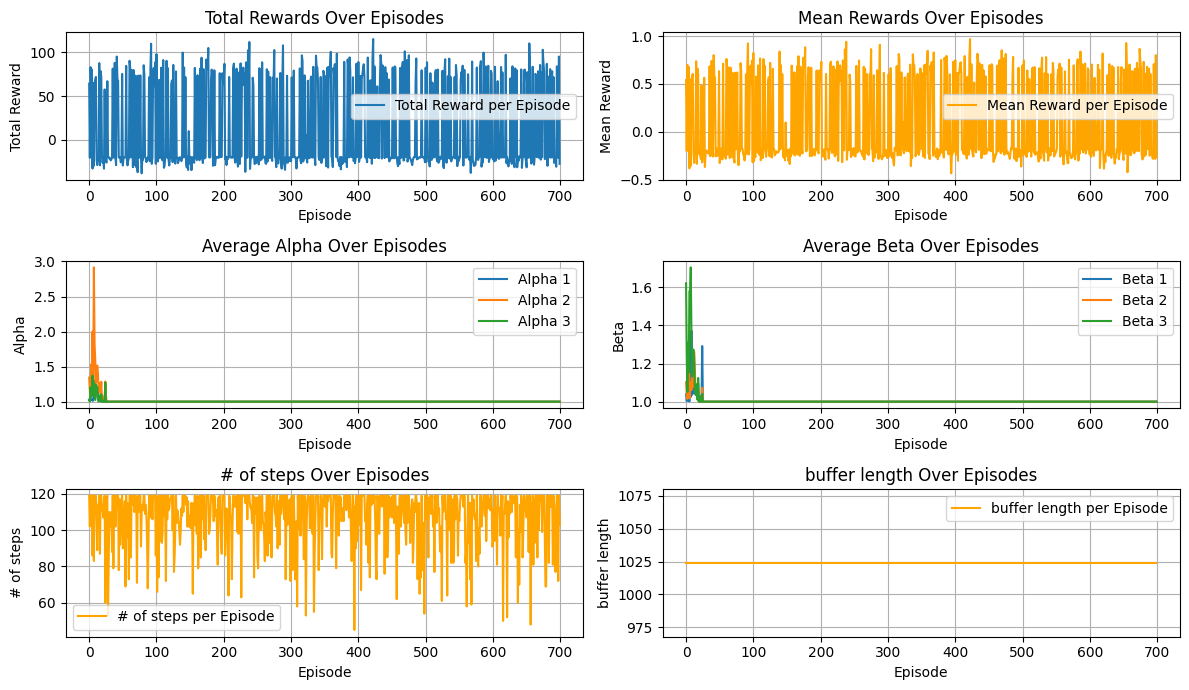

100%|█████████████████████████████████████| 700/700 [49:58:48<00:00, 257.04s/it]


In [9]:
agent.train(env, episodes=700)

In [12]:
agent.mean_rewards_history = []
agent.total_rewards_history = []

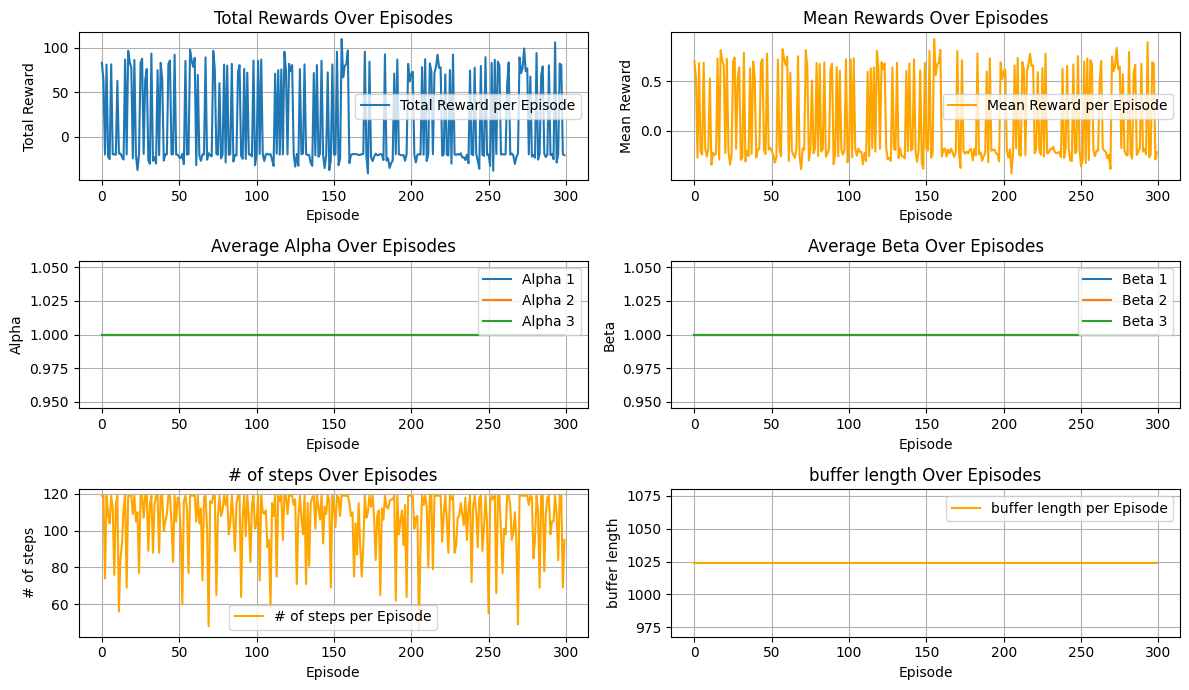

100%|█████████████████████████████████████| 300/300 [21:15:27<00:00, 255.09s/it]


In [13]:
agent.train(env, episodes=300)